In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

In [2]:
# Specify training or testing and seeds to average over
training = False
seeds = [7, 13, 42, 69, 77, 101, 420, 12345, 80085, 31415]

dfs = []
for seed in seeds:
    filename = f"../checkpoints/seed_{seed}_" + ['test', 'training'][int(training)] + "_metrics.pkl"
    df = pd.read_pickle(filename)
    df = df.drop(columns=["Predicted_Class_MC", "Variance_of_Gradients_Early", "Variance_of_Gradients_Late"])
    df = df.rename(columns={"vog": "VoG"})
    df = df.rename(columns={
        "Mean_Std_Deviation": "MSTD", 
        'Predictive_Entropy': 'PE', 
        'Mutual_Information': 'MI', 
        'Variation_Ratio': 'VR',
        'Learning_Speed': 'LS'    
    })
    df = df.rename(columns={col: col.replace("_", " ") for col in df.columns})
    dfs.append(df)
    
# average over seeds
concatenated = pd.concat(dfs, axis=0)
averaged_df = concatenated.groupby(concatenated.index).mean()

### Training Dynamics

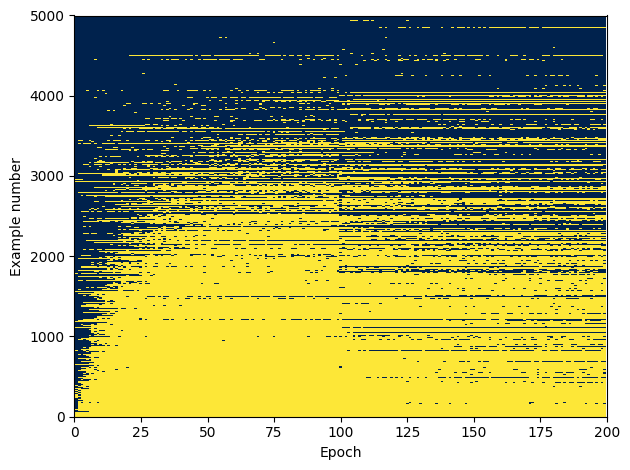

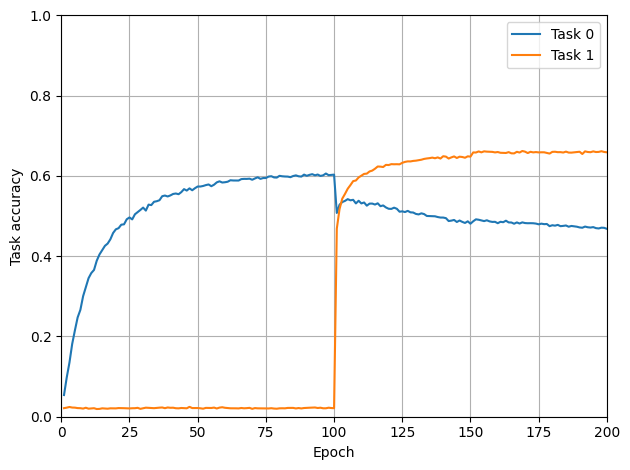

In [3]:
# Recreate plots from the paper by using the stored epoch-wise-classification matrices
sortby = "LS"
desc = True

matrices = []
for seed in seeds:
    filename = "../checkpoints/matrices_" + ['test', 'train'][int(training)] + f"_seed{seed}"
    with open(filename, "rb") as f:
        matrices.append(pickle.load(f))
averaged_matrices = torch.mean(torch.stack(matrices, dim=0), dim=0)

if training:
    size = 25000
else:
    size = 5000

boolean_matrices = (averaged_matrices >= 0.5).float()
_, sorted_indices = torch.sort(torch.tensor(dfs[2][sortby]), descending=desc)
matrix = boolean_matrices[0].reshape(size, 200)
sorted_matrix = matrix[sorted_indices]
plt.figure()
plt.imshow(sorted_matrix.numpy(), cmap='cividis', interpolation='nearest', aspect='auto')
plt.xlabel("Epoch")
plt.ylabel("Example number")
plt.xlim((0,200))
plt.ylim((0, size))
plt.tight_layout()
#plt.savefig("averaged_" + ['test', 'training'][int(training)] + "_heatmap.pdf")
plt.show()

mean_accuracies = averaged_matrices.mean(dim=1).reshape(2, 200)
plt.figure()
plt.plot(np.arange(1, 201, 1), mean_accuracies[0], label="Task 0")
plt.plot(np.arange(1, 201, 1), mean_accuracies[1], label="Task 1")
plt.xlabel("Epoch")
plt.ylabel("Task accuracy")
plt.xlim((0,200))
plt.ylim((0, 1))
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig("averaged_" + ['test', 'training'][int(training)] + "_accuracy.pdf")
plt.show()

### Correlation Analysis

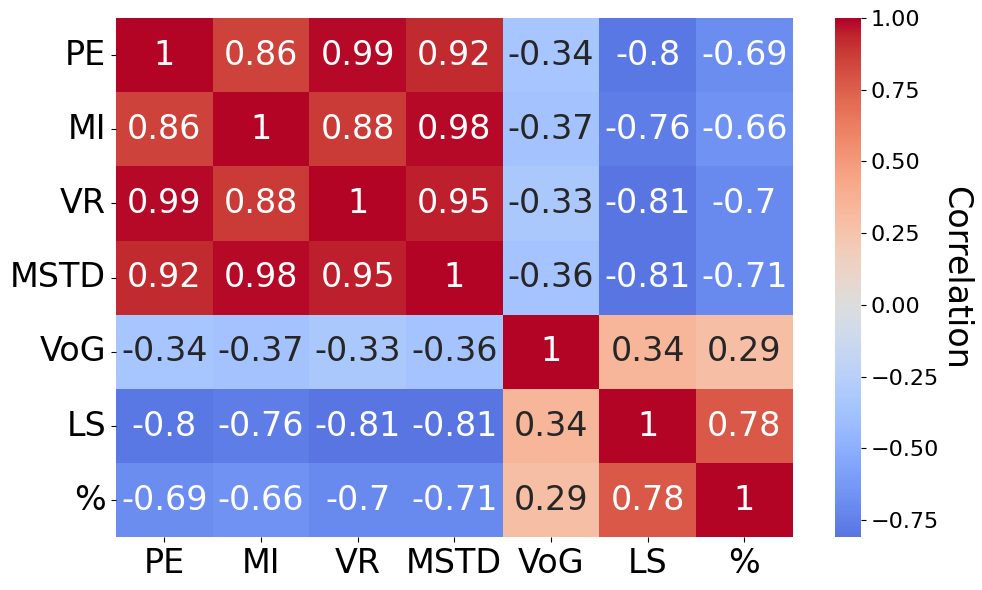

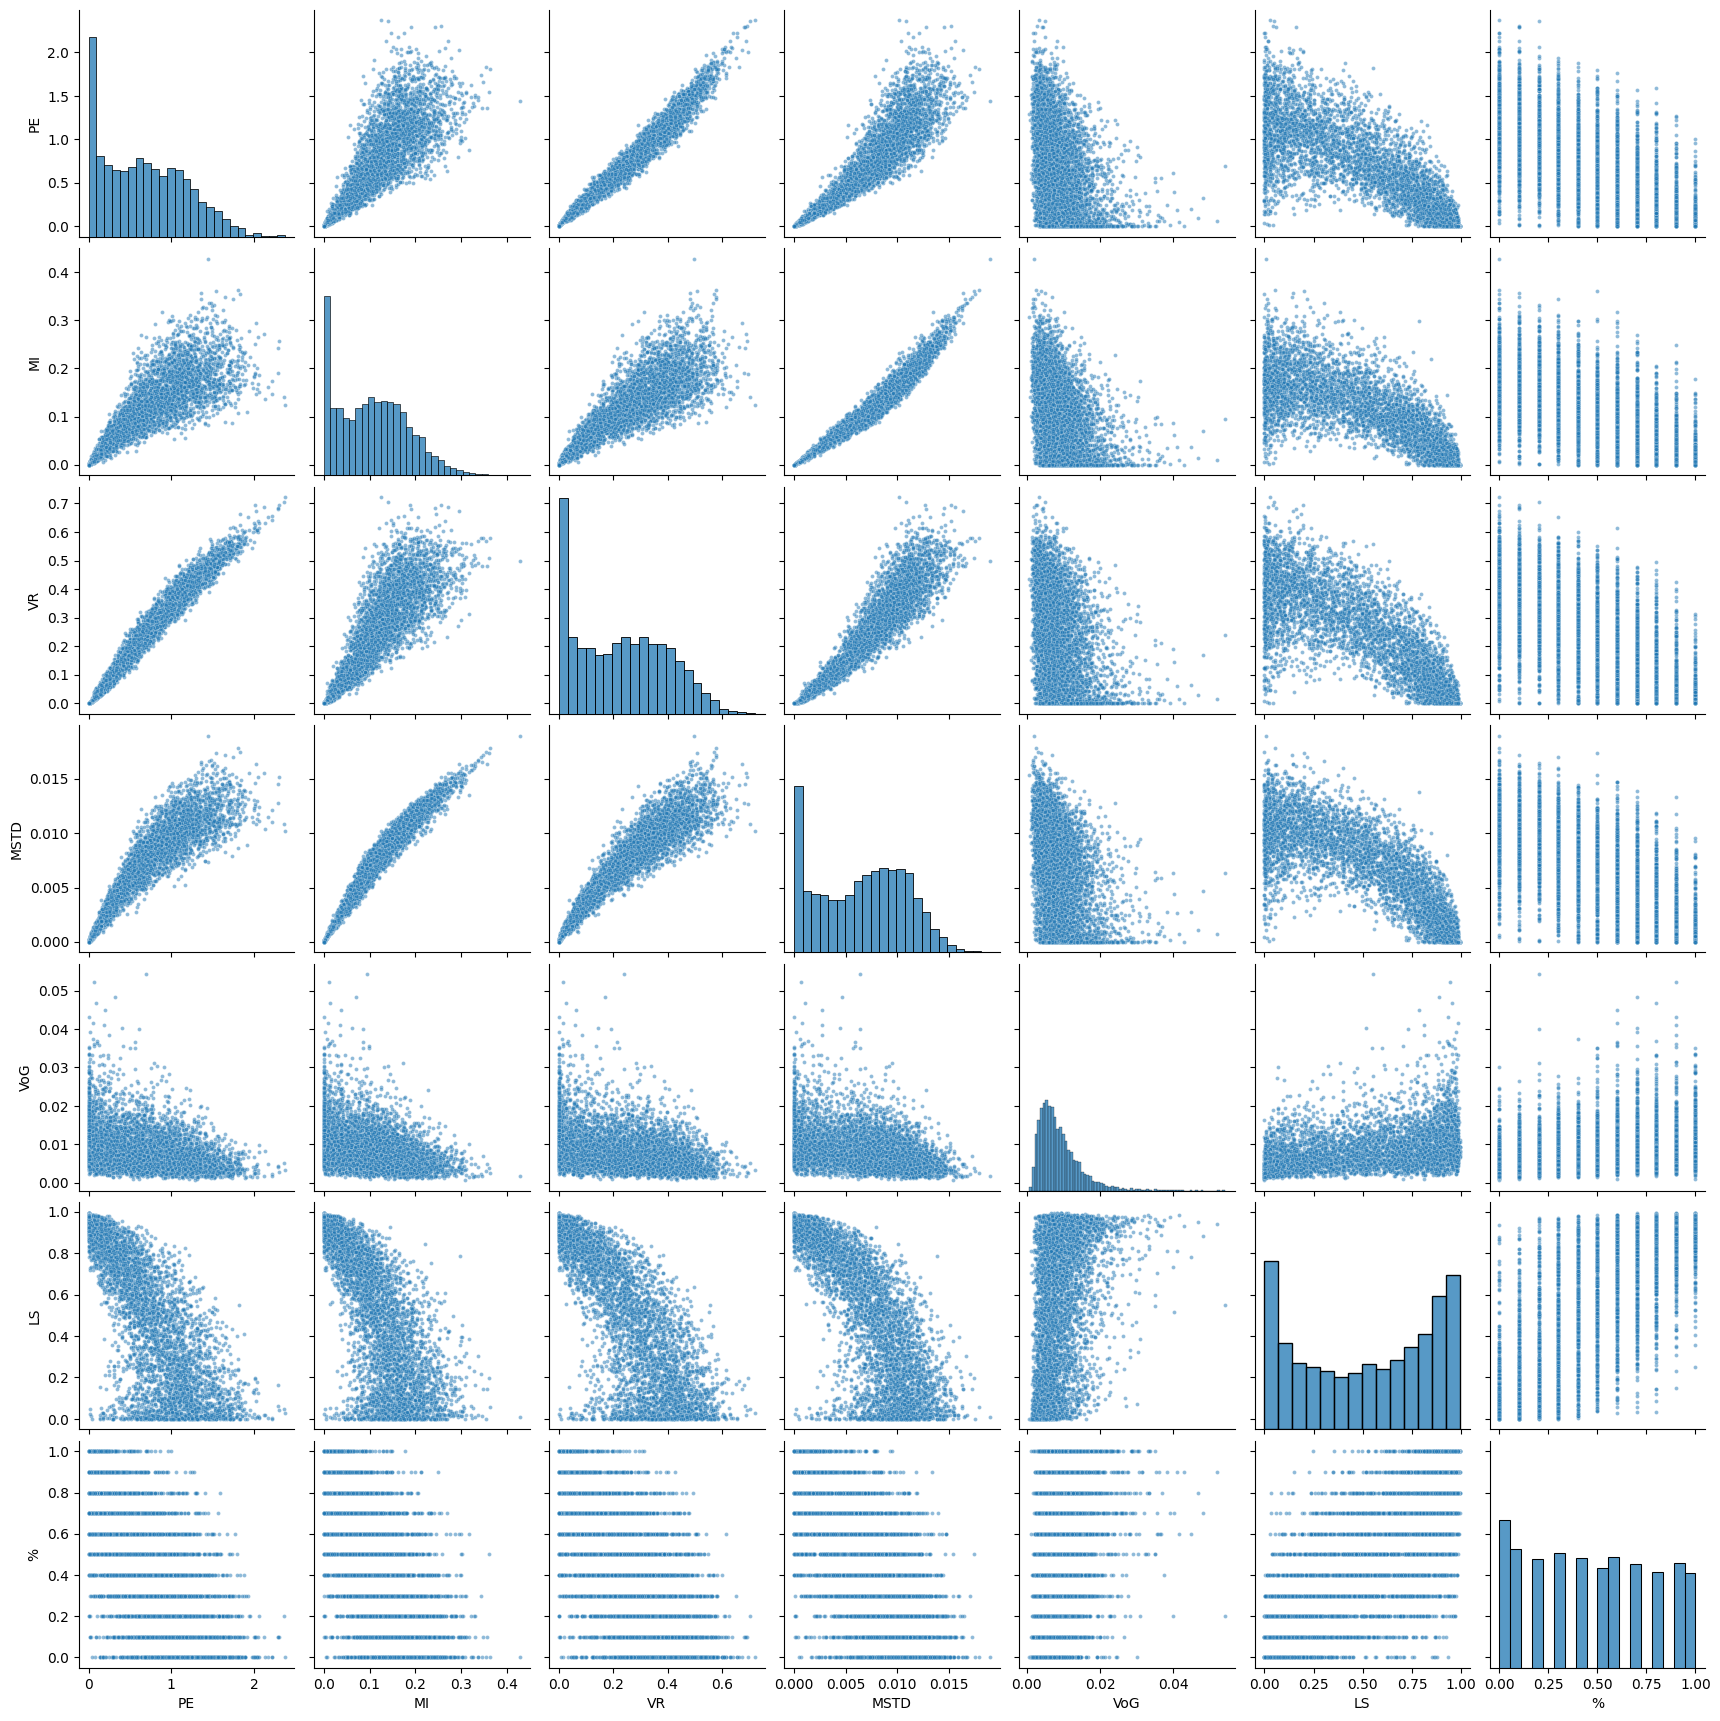

In [4]:
final_accuracies = averaged_matrices[0,:, 1, -1]
averaged_df["%"] = final_accuracies

# Generate heatmap of correlation
correlation_matrix = averaged_df.corr()

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
heatmap = sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    center = 0.0,
    cbar_kws={'label': 'Correlation', 'orientation' : 'vertical'}
)
# Customize the color bar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Adjust tick label size
cbar.set_label('Correlation', size=32, labelpad=15)  # Adjust label size and padding
cbar.ax.xaxis.set_label_position('top')  # Set the label position to top
cbar.ax.xaxis.set_ticks_position('top')  # Move the ticks to the top
cbar.ax.set_ylabel('Correlation', rotation=270, size=24, labelpad=24) 
plt.xticks(rotation=0, ha='center')  # Rotate x-axis labels, align to the right
plt.yticks(rotation=0, va='center') 
plt.tick_params(axis='both', which='major', labelsize=24)  # Adjust tick label size
# increase font size within cells
for text in heatmap.texts:
    text.set_size(24)

# Display the plot
plt.tight_layout()
#plt.savefig("correlation_matrix_" + ['test', 'training'][int(training)] + ".pdf")
plt.show()
sns.pairplot(averaged_df, plot_kws={"s": 8, "alpha":0.5});

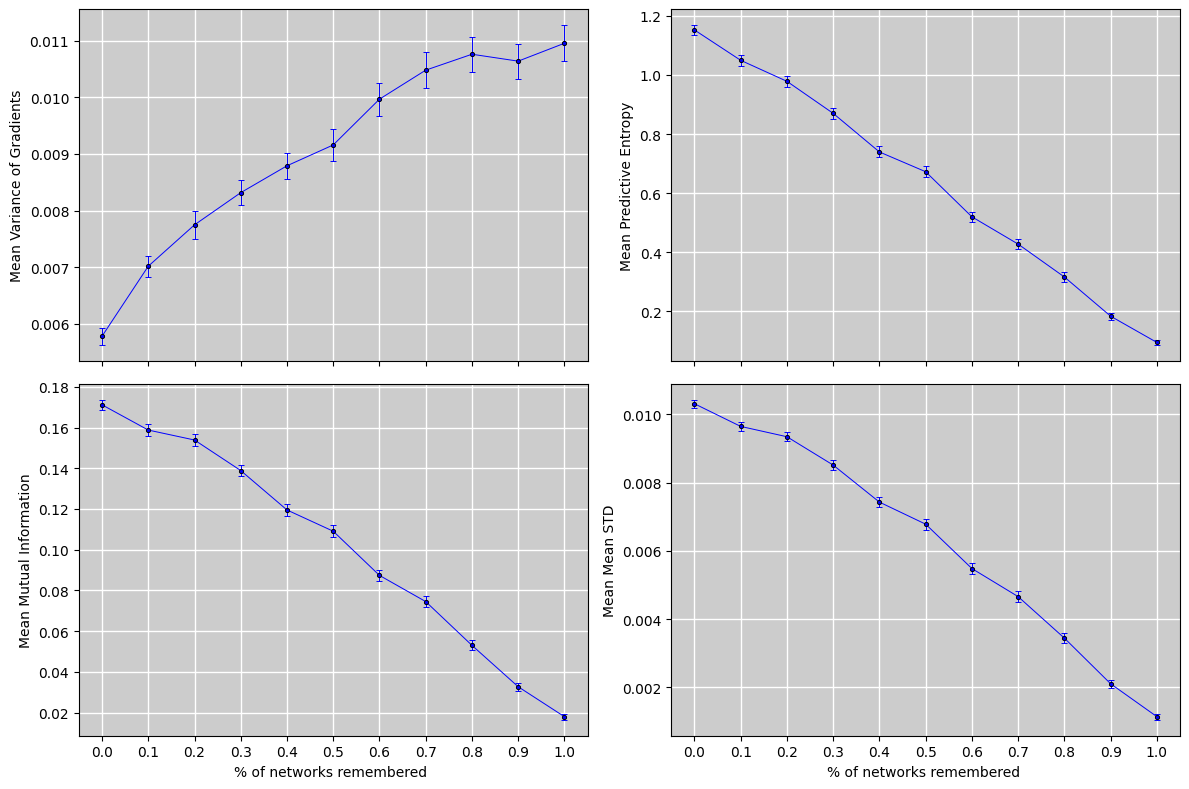

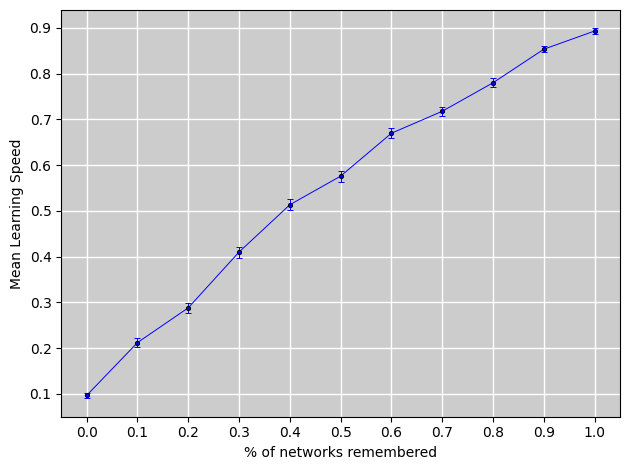

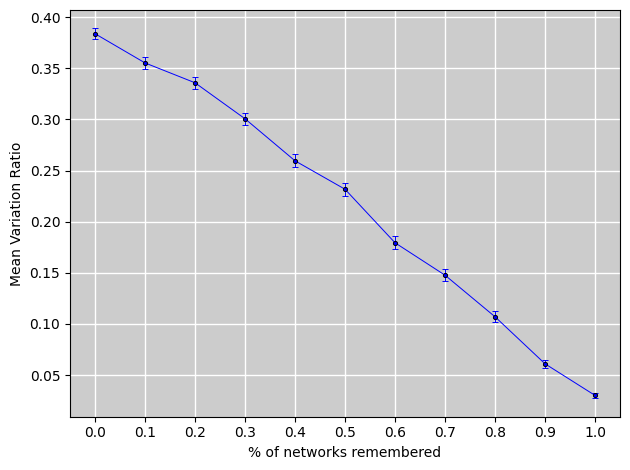

In [5]:
# Correlate catastrophic forgetting with all metrics

# Group by % of networks remembered and aggregate mean and standard devation of metrics
grouped = averaged_df.groupby('%', observed=False).agg(
    Count = ("LS", "count"),
    Predictive_Entropy_Mean=('PE', 'mean'),
    Predictive_Entropy_Std=('PE', 'std'),
    Mutual_Information_Mean=('MI', 'mean'),
    Mutual_Information_Std=('MI', 'std'),
    Variation_Ratio_Mean=('VR', 'mean'),
    Variation_Ratio_Std=('VR', 'std'),
    Mean_STD_Mean=('MSTD', 'mean'),
    Mean_STD_Std=('MSTD', 'std'),
    Variance_of_Gradients_Mean =('VoG', 'mean'),
    Variance_of_Gradients_Std=('VoG', 'std'),
    Learning_Speed_Mean=('LS', 'mean'),
    Learning_Speed_Std=('LS', 'std'),
    
).reset_index()

# Plot with error bars
variables_to_plot = [
    ('Variance_of_Gradients_Mean', 'Variance_of_Gradients_Std'),
    ('Predictive_Entropy_Mean', 'Predictive_Entropy_Std'),
    ('Mutual_Information_Mean', 'Mutual_Information_Std'),
    ('Mean_STD_Mean', 'Mean_STD_Std'),

]

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for i, (y_mean, y_std) in enumerate(variables_to_plot):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    ax.errorbar(
        grouped['%'],
        grouped[y_mean],
        yerr=grouped[y_std]/np.sqrt(grouped["Count"]),
        fmt='o',
        color='blue',
        markeredgecolor='black',
        markersize=3,
        markeredgewidth=0.7,
        linestyle='-',
        linewidth=0.7,
        capsize=2,
        elinewidth=0.7,
        capthick=0.7,
    )
    ax.set_facecolor('0.8')
    ax.grid(True, linestyle='-', linewidth=1, color='white')
    ax.set_xticks(np.arange(0, 1.1, 0.1))

    if row == 1:
        ax.set_xlabel('% of networks remembered ')
    ax.set_ylabel("Mean " + y_mean.replace('_Mean', '').replace('_', ' '))

plt.tight_layout()
#plt.savefig("forgetting_vs_othermetrics_" + ['test', 'training'][int(training)] + ".pdf")
plt.show()

plt.figure()
plt.errorbar(
        grouped['%'],
        grouped['Learning_Speed_Mean'],
        yerr=grouped['Learning_Speed_Std']/np.sqrt(grouped["Count"]),
        fmt='o',
        color='blue',
        markeredgecolor='black',
        markersize=3,
        markeredgewidth=0.7,
        linestyle='-',
        linewidth=0.7,
        capsize=2,
        elinewidth=0.7,
        capthick=0.7,
    )
plt.xlabel('% of networks remembered')
plt.ylabel("Mean Learning Speed")
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.grid(True, which='major', linestyle='-', linewidth=1, color='white')
plt.gca().set_facecolor('0.8')
plt.tight_layout()
#plt.savefig("forgetting_vs_learning_speed_" + ['test', 'training'][int(training)] + ".pdf")
plt.show();

plt.figure()
plt.errorbar(
        grouped['%'],
        grouped['Variation_Ratio_Mean'],
        yerr=grouped['Variation_Ratio_Std']/np.sqrt(grouped["Count"]),
        fmt='o',
        color='blue',
        markeredgecolor='black',
        markersize=3,
        markeredgewidth=0.7,
        linestyle='-',
        linewidth=0.7,
        capsize=2,
        elinewidth=0.7,
        capthick=0.7,
    )
plt.xlabel('% of networks remembered')
plt.ylabel("Mean Variation Ratio")
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.grid(True, which='major', linestyle='-', linewidth=1, color='white')
plt.gca().set_facecolor('0.8')
plt.tight_layout()
#plt.savefig("forgetting_vs_variation_ratio_" + ['test', 'training'][int(training)] + ".pdf")
plt.show();

### Cutoff Point Analysis

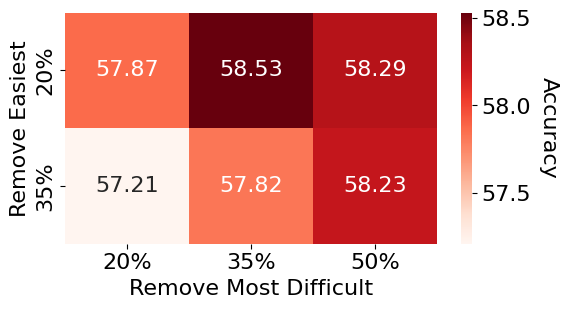

In [6]:
results = [[57.87, 58.53, 58.29], [57.21, 57.82, 58.23]]
df = pd.DataFrame(results)

plt.figure(figsize=(6, 3))
heatmap = sns.heatmap(
    df,
    annot=True,
    fmt='.2f',
    cmap='Reds',
    xticklabels=["20%", "35%", "50%"],
    yticklabels=["20%", "35%"], 
    cbar_kws={'label': 'Accuracy', 'orientation' : 'vertical'}
)
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)  # Adjust tick label size
cbar.set_label('Accuracy', size=16, labelpad=15)  # Adjust label size and padding
cbar.ax.xaxis.set_label_position('top')  # Set the label position to top
cbar.ax.xaxis.set_ticks_position('top')  # Move the ticks to the top
cbar.ax.set_ylabel('Accuracy', rotation=270, size=16, labelpad=20) 
plt.tick_params(axis='both', which='major', labelsize=16) 

for text in heatmap.texts:
    text.set_size(16)

plt.xlabel("Remove Most Difficult", size=16)
plt.ylabel("Remove Easiest", size=16);

### Other

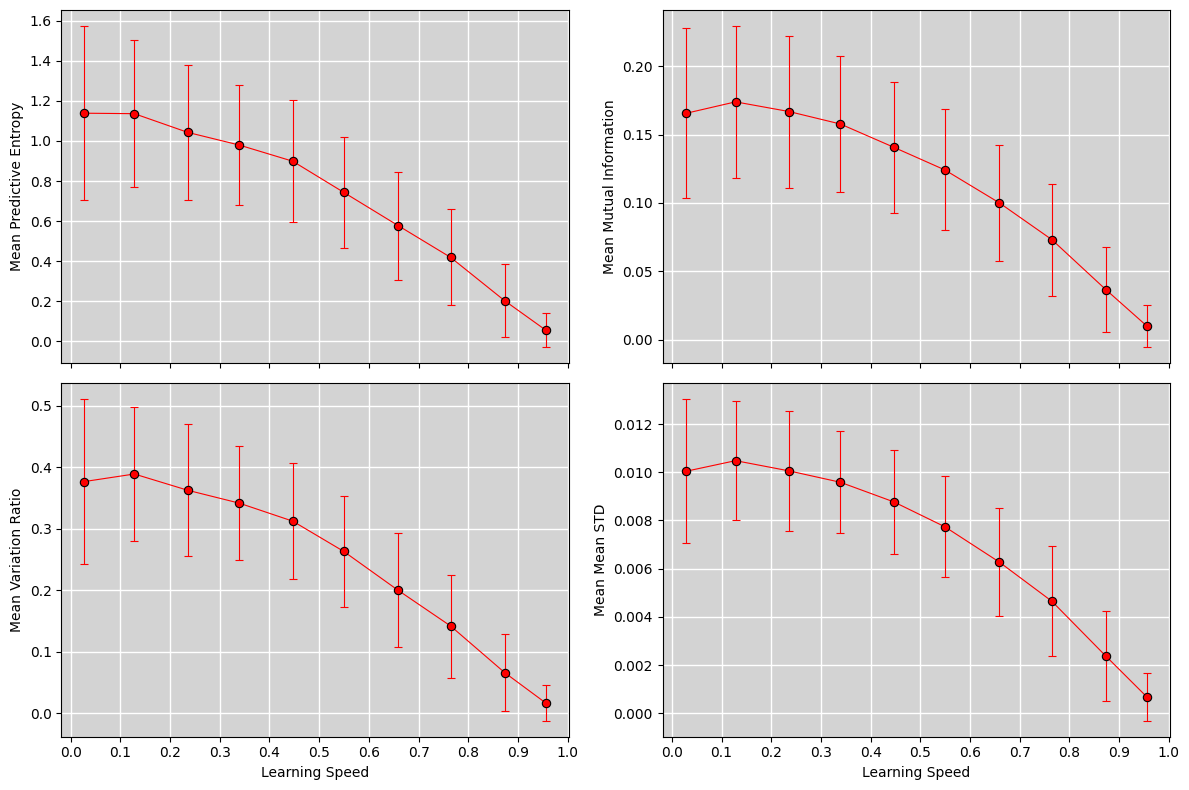

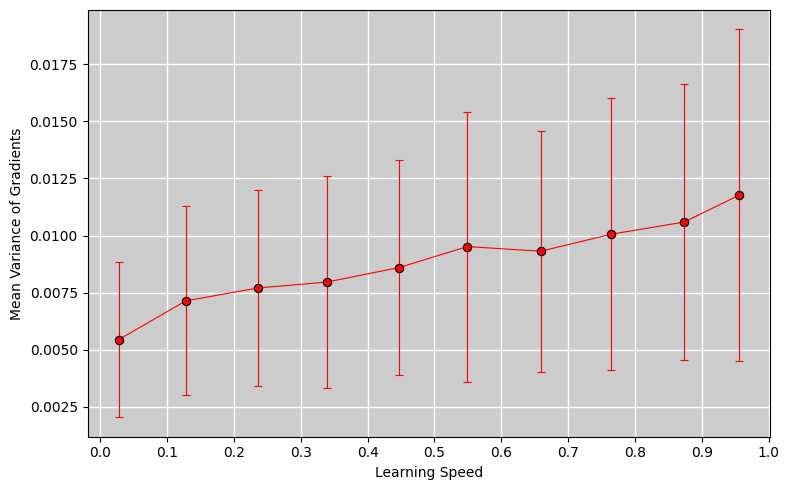

In [7]:
df = averaged_df
# Define bins for grouping Learning Speed
learning_speed_bins = np.linspace(-0.025, 1.025, 11)
df['Learning_Speed_Binned'] = pd.cut(df['LS'], bins=learning_speed_bins)

#percentiles = np.linspace(0, 100, 11)  # Define bins: 0-10%, 10-20%, ..., 90-100%
#df['Percentile_Range'] = pd.qcut(df['Learning Speed'], q=percentiles/100, labels=percentiles[:-1] + 5)

# Group by Learning Speed bins and calculate mean and standard deviation for each bin
grouped = df.groupby('Learning_Speed_Binned', observed=False).agg(
    Average_Learning_Speed=('LS', 'mean'),
    Std_Learning_Speed=('LS', 'std'),
    Predictive_Entropy_Mean=('PE', 'mean'),
    Predictive_Entropy_Std=('PE', 'std'),
    Mutual_Information_Mean=('MI', 'mean'),
    Mutual_Information_Std=('MI', 'std'),
    Variation_Ratio_Mean=('VR', 'mean'),
    Variation_Ratio_Std=('VR', 'std'),
    Mean_STD_Mean=('MSTD', 'mean'),
    Mean_STD_Std=('MSTD', 'std'),
    Variance_of_Gradients_Mean =('VoG', 'mean'),
    Variance_of_Gradients_Std=('VoG', 'std'),
).reset_index()

# Plot with error bars
variables_to_plot = [
    ('Predictive_Entropy_Mean', 'Predictive_Entropy_Std'),
    ('Mutual_Information_Mean', 'Mutual_Information_Std'),
    ('Variation_Ratio_Mean', 'Variation_Ratio_Std'),
    ('Mean_STD_Mean', 'Mean_STD_Std')
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
for i, (y_mean, y_std) in enumerate(variables_to_plot):
    row, col = i // 2, i % 2
    ax = axs[row, col]
    ax.errorbar(
        grouped['Average_Learning_Speed'],
        grouped[y_mean],
        #xerr = grouped['Std_Learning_Speed'],
        yerr=grouped[y_std],
        fmt='o',
        color='red',
        markeredgecolor='black',
        markeredgewidth=0.8,
        linestyle='-',
        linewidth=0.8,
        capsize=3,
        elinewidth=0.8,
        capthick=0.8,
    )
    ax.set_facecolor('lightgray')
    ax.grid(True, linestyle='-', linewidth=1, color='white')

    if row == 1:
        ax.set_xlabel('Learning Speed')
    ax.set_ylabel("Mean " + y_mean.replace('_Mean', '').replace('_', ' '))
    ax.set_xticks(np.arange(0.0, 1.1, 0.1))

plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
plt.errorbar(
        grouped['Average_Learning_Speed'],
        grouped['Variance_of_Gradients_Mean'],
        #xerr = grouped['Std_Learning_Speed'],
        yerr=grouped['Variance_of_Gradients_Std'],
        fmt='o',
        color='red',
        markeredgecolor='black',
        markeredgewidth=0.8,
        linestyle='-',
        linewidth=0.8,
        capsize=3,
        elinewidth=0.8,
        capthick=0.8,
    )
plt.xlabel('Learning Speed')
plt.ylabel("Mean Variance of Gradients")
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.grid(True, which='major', linestyle='-', linewidth=1, color='white')
plt.gca().set_facecolor('0.8')
plt.tight_layout()
plt.show();